In [1]:
print("Trabajo Practico N°2: Grid")
#Para mostrar las imagenes en ventanas emergentes saca el inline
%matplotlib inline

#Agregamos numpy para usar OpenCV
import numpy as np
#Agregamos cv2 para acceder a OpenCV
import cv2 as cv
#Agregamos para ver los graficos
import matplotlib.pyplot as plt

Trabajo Practico N°2: Grid


In [3]:
#Cargar imagen
img = cv.imread('metalgrid.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [4]:
def normalize(img):
    img = img + np.abs(img.min())
    img = img / img.max()
    return img

In [5]:
def plot_fig(img, fsize = (8, 8)):
    fig = plt.figure(figsize = fsize, dpi = 130)
    if len(img) == 1:
        img1=plt.subplot(111)
        img1.imshow(normalize(img[0]), cmap='gray')
    if len(img) == 2:
        img1=plt.subplot(121)
        img1.imshow(normalize(img[0]), cmap='gray')
        img2=plt.subplot(122)
        img2.imshow(normalize(img[1]), cmap='gray')

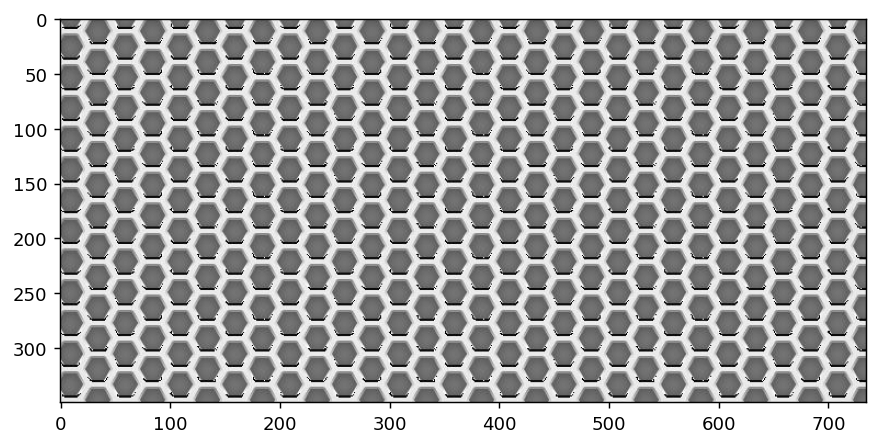

In [7]:
#Imprimimos imagen a trabajar
plot_fig([img])

In [8]:
#Reducimos ruido usando filtro de gauss
img_blur = cv.GaussianBlur(img,(7, 7), 0)

In [9]:
#Filtro de sobel en 2 direcciones
DirX = cv.Sobel(img_blur, cv.CV_64F,1,0,ksize=5)
DirY = cv.Sobel(img_blur, cv.CV_64F,0,1,ksize=5)

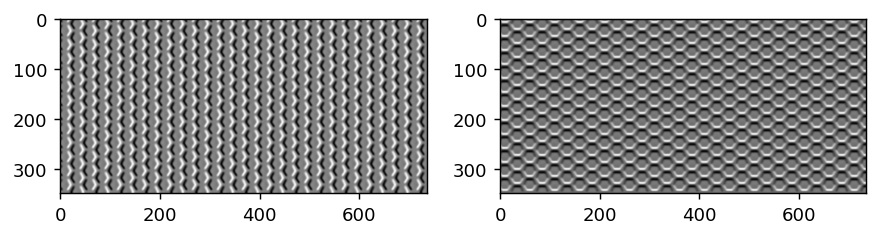

In [10]:
plot_fig([DirX, DirY])

In [11]:
#Encontrar gradiente de intensidad (Magnitud y direccion)
Dir = (DirX**2 + DirY**2)**0.5
tita = np.arctan2(DirY, DirX)

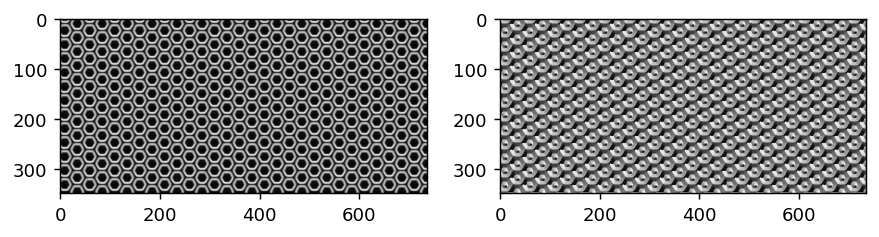

In [12]:
plot_fig([Dir, tita])

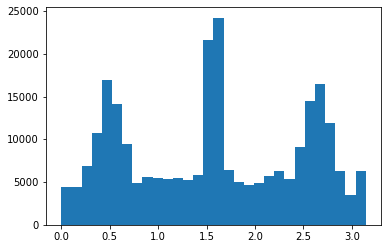

In [18]:
#Histograma de direccion del gradiente
tita[tita <= 0] += np.pi
plt.hist(tita.ravel(), bins=30, range = (0, np.pi));

In [21]:
#Umbrales de magnitud del gradiente
p = 90 #Percentil
limit = np.percentile(Dir.ravel(),p).round()
print("Magnitud minima: " + str(Dir.min()))
print("Magnitud minima: " + str(Dir.max()))
print("Percentil " + str(p) + ": " + str(limit))

Magnitud minima: 0.0
Magnitud minima: 4485.6451041071
Percentil 90: 3446.0


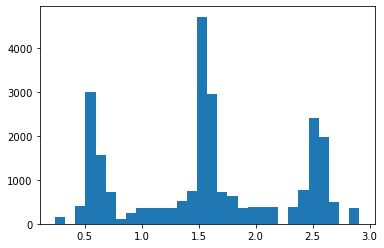

In [23]:
# Histograma de direcciones del gradiente con umbral de magnitud
tita_f = tita[Dir > limit]
plt.hist(tita_f.ravel(), bins=30);

In [24]:
# Filtrar N bins y calcular medias (Direcciones principales)
N = 3
hist, bin_edges = np.histogram(tita_f.ravel(), bins=40)
idx = np.argsort(hist*-1)[:N]
means = ((bin_edges[idx + 1] + bin_edges[idx])/2)
print("Direcciones principales (deg): " + str(means*180/np.pi))

Direcciones principales (deg): [ 88.24572016  34.71886859 145.59591828]


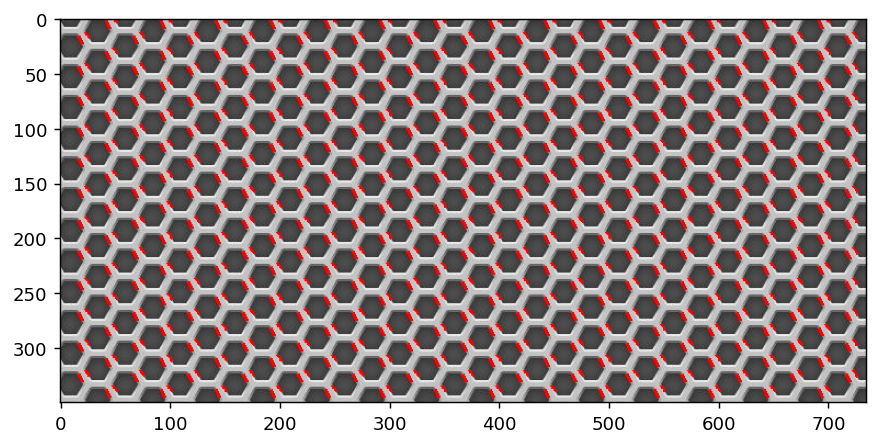

In [30]:
# Detectar bordes con cierta dirección en la imagen
deg = 155 #25, 90, 155
tol_deg = 10

rad = deg*np.pi/180.0
tol_deg = tol_deg*np.pi/180.0

limit = np.percentile(Dir.ravel(),70).round() # umbral de intensidad
idx = (tita > rad-tol_deg)&(tita < rad+tol_deg)&(Dir > limit)

result = cv.cvtColor(img,cv.COLOR_GRAY2RGB).copy()
result[idx,:] = [255,0,0]
plot_fig([result])

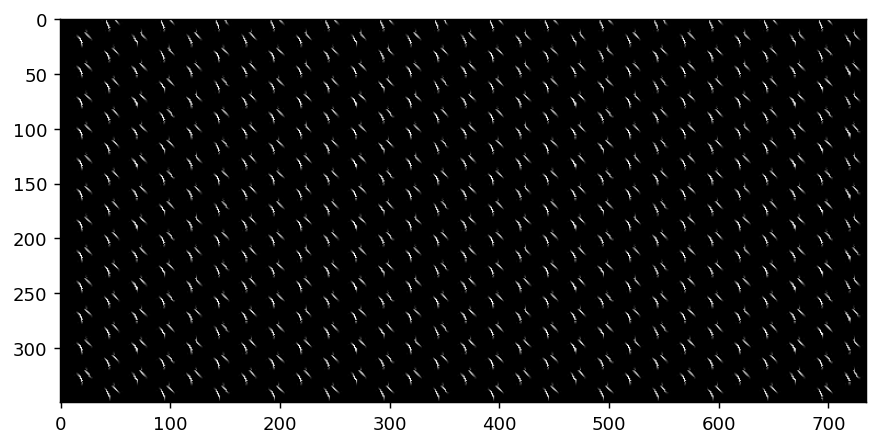

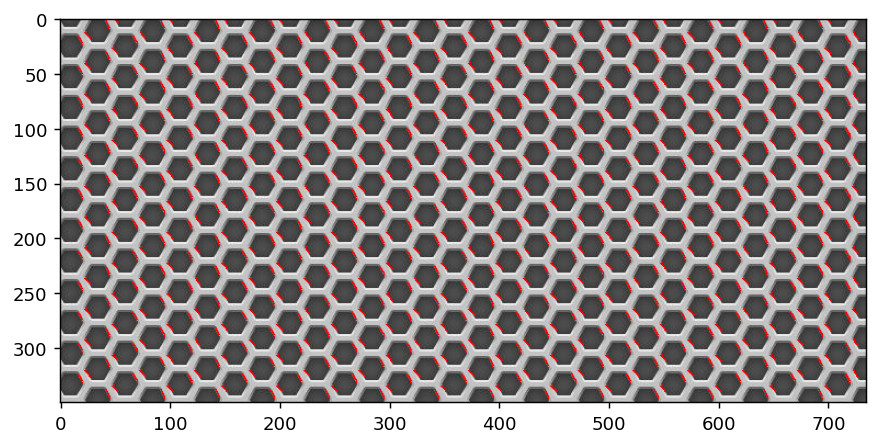

In [31]:
# Solución con supresión de no maximos a los bordes detectados

borders = 0*img
borders[idx] = 255
borders = cv.GaussianBlur(borders,(9,9),0) # Evitar bordes gruesos con valores constantes

M, N = borders.shape
Non_max = np.zeros((M,N), dtype= np.uint8)
angle = np.rad2deg(tita)

for i in range(1,M-1):
    for j in range(1,N-1):
       # Horizontal 0
        if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or (-22.5 <= angle[i,j] < 0) or (-180 <= angle[i,j] < -157.5):
            b = borders[i, j+1]
            c = borders[i, j-1]
        # Diagonal 45
        elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
            b = borders[i+1, j+1]
            c = borders[i-1, j-1]
        # Vertical 90
        elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
            b = borders[i+1, j]
            c = borders[i-1, j]
        # Diagonal 135
        elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
            b = borders[i+1, j-1]
            c = borders[i-1, j+1]           
            
        # Supresión de no-máximos
        if (borders[i,j] >= b) and (borders[i,j] >= c):
            Non_max[i,j] = borders[i,j]
        else:
            Non_max[i,j] = 0

plot_fig([Non_max])
idx2 = Non_max > 50

result = cv.cvtColor(img,cv.COLOR_GRAY2RGB).copy()
result[idx2,:] = [255,0,0]
plot_fig([result])